In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
MLOST = xr.open_dataset('/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/SpatialPattern/SAT-OBS-Model/seasonalData/tas_MLOST_ano.nc')
MLOST_ano =MLOST.sel(time=slice('1958-01-01','2022-12-31'))

MLOST_ano


<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2022-12-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Data variables:
    air      (time, lat, lon) float32 ...

In [3]:
MLOST_ano['DJF'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='DJF').groupby('time.year').mean('time')
MLOST_ano['MAM'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='MAM').groupby('time.year').mean('time')
MLOST_ano['JJA'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='JJA').groupby('time.year').mean('time')
MLOST_ano['SON'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='SON').groupby('time.year').mean('time')

## Define function

In [4]:
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

## MLOST seasonal trend pattern

In [5]:
MLOST_ano['DJF_trend'], MLOST_ano['p_value_DJF'] = xr.apply_ufunc(calc_trend, MLOST_ano['DJF'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
MLOST_ano['MAM_trend'], MLOST_ano['p_value_MAM'] = xr.apply_ufunc(calc_trend, MLOST_ano['MAM'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
MLOST_ano['JJA_trend'], MLOST_ano['p_value_JJA'] = xr.apply_ufunc(calc_trend, MLOST_ano['JJA'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
MLOST_ano['SON_trend'], MLOST_ano['p_value_SON'] = xr.apply_ufunc(calc_trend, MLOST_ano['SON'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)

In [6]:
SAT_trend = xr.Dataset({
    'DJF': MLOST_ano['DJF_trend']*65.0,
    'MAM': MLOST_ano['MAM_trend']*65.0,
    'JJA': MLOST_ano['JJA_trend']*65.0,
    'SON': MLOST_ano['SON_trend']*65.0
}, coords={'longitude': MLOST_ano['lon'], 'latitude': MLOST_ano['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
SAT_trend

<xarray.Dataset>
Dimensions:    (lon: 180, lat: 45, season: 4)
Coordinates:
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    longitude  (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    latitude   (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    DJF        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MAM        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    JJA        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    SON        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [7]:
sig_ds = xr.Dataset({
    'DJF': MLOST_ano['p_value_DJF'],
    'MAM': MLOST_ano['p_value_MAM'],
    'JJA': MLOST_ano['p_value_JJA'],
    'SON': MLOST_ano['p_value_SON']
}, coords={'longitude': MLOST_ano['lon'], 'latitude': MLOST_ano['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
sig_ds

<xarray.Dataset>
Dimensions:    (lon: 180, lat: 45, season: 4)
Coordinates:
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    longitude  (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    latitude   (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    DJF        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MAM        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    JJA        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    SON        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

## MPI-ESM-Trend Calculating

In [8]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2022_*.nc'
ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [9]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [10]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)
masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 2076, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 2076, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [11]:
tas = masked_tas['tas'].loc[:,'1958-01-01':'2022-12-31',0:90,:]
tas = tas - 273.15
print(tas.min().values)
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_climatology
tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano_ds = tas_ano.to_dataset()
tas_ano_ds

-51.692596


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [12]:
seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = tas_ano_ds.sel(time=tas.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies['tas']

# Access the multiyear JJA mean SAT anomalies
    
tas_ano_ds['JJA'] = season_means['JJA']
tas_ano_ds['DJF'] = season_means['DJF']
tas_ano_ds['MAM'] = season_means['MAM']
tas_ano_ds['SON'] = season_means['SON']

tas_ano_ds

<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [13]:
import scipy.stats as stats
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

In [14]:
tas_ano_ds['slope_JJA'], tas_ano_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, tas_ano_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_JJA'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_JJA'].attrs['units'] = 'p_value'

In [15]:
tas_ano_ds['slope_DJF'], tas_ano_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, tas_ano_ds['DJF'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_DJF'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_DJF'].attrs['units'] = 'p_value'

In [16]:
tas_ano_ds['slope_MAM'], tas_ano_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, tas_ano_ds['MAM'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_MAM'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_MAM'].attrs['units'] = 'p_value'

In [17]:
tas_ano_ds['slope_SON'], tas_ano_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, tas_ano_ds['SON'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_SON'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_SON'].attrs['units'] = 'p_value'

In [18]:
tas_ano_ds = tas_ano_ds.compute()

In [19]:
tas_ano_ds

<xarray.Dataset>
Dimensions:      (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time         (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:...
  * lon          (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat          (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    height       (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * year         (year) int64 1958 1959 1960 1961 1962 ... 2019 2020 2021 2022
Dimensions without coordinates: run
Data variables: (12/13)
    tas          (run, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    JJA          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    DJF          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    MAM          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    SON          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    slope_JJA    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    slope_DJF    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    p_value_DJF  (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    slope_MAM    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    p_value_MAM  (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    slope_SON    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    p_value_SON  (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

## Calculate the pattern correlations

In [36]:
#define thr function to calculate the pattern correlation
from scipy.stats import pearsonr
def pattern_correlation(x, y):
    """ Pattern Correlation function """
    # Ensure that data are properly alinged to each other
    #convert the two dimensions to the one dimension without the nan values
    
    x_flat = x.flatten()
    y_flat = y.flatten()

    #remove the nan values
    x_flat = x_flat[~np.isnan(x_flat)]
    y_flat = y_flat[~np.isnan(y_flat)]
    # x,y = xr.align(x,y)
    corr, pval = pearsonr(x_flat,y_flat)

    return corr

In [39]:
# Define the output core dimensions for the pattern_correlation function
# output_core_dims = [[], []]
input_core_dims = [['lat', 'lon'], ['lat', 'lon']]
# Calculate the pattern correlation for DJF
pattern_corr_DJF = xr.apply_ufunc(pattern_correlation, SAT_trend['DJF'], tas_ano_ds['slope_DJF'], input_core_dims=input_core_dims, output_core_dims=[[]], vectorize=True)

# Add units to the pattern correlation data array
pattern_corr_DJF.attrs['units'] = 'pattern correlation'

# Display the pattern correlation data array
pattern_corr_DJF

<xarray.DataArray (run: 30)>
array([0.49960812, 0.49797338, 0.29930499, 0.50773123, 0.73304037,
       0.37055814, 0.64714502, 0.20038617, 0.36709941, 0.68702915,
       0.50166884, 0.50608003, 0.5974046 , 0.6006229 , 0.52211748,
       0.4668645 , 0.47845105, 0.25684624, 0.50597492, 0.35958141,
       0.42822829, 0.59203951, 0.60263059, 0.50731133, 0.58878051,
       0.55003111, 0.43672526, 0.58945505, 0.54594952, 0.73004262])
Dimensions without coordinates: run
Attributes:
    units:    pattern correlation

In [41]:
pattern_corr_MAM = xr.apply_ufunc(pattern_correlation, SAT_trend['MAM'], tas_ano_ds['slope_MAM'], input_core_dims=input_core_dims, output_core_dims=[[]], vectorize=True)
pattern_corr_MAM.attrs['units'] = 'pattern correlation'
pattern_corr_MAM

pattern_corr_JJA = xr.apply_ufunc(pattern_correlation, SAT_trend['JJA'], tas_ano_ds['slope_JJA'], input_core_dims=input_core_dims, output_core_dims=[[]], vectorize=True)
pattern_corr_JJA.attrs['units'] = 'pattern correlation'
pattern_corr_JJA

pattern_corr_SON = xr.apply_ufunc(pattern_correlation, SAT_trend['SON'], tas_ano_ds['slope_SON'], input_core_dims=input_core_dims, output_core_dims=[[]], vectorize=True)
pattern_corr_SON.attrs['units'] = 'pattern correlation'
pattern_corr_SON

<xarray.DataArray (run: 30)>
array([0.5668994 , 0.67621385, 0.59401638, 0.43377103, 0.52485413,
       0.380275  , 0.61217252, 0.57971726, 0.6545525 , 0.65463416,
       0.54198726, 0.55588694, 0.55992718, 0.64543879, 0.65132603,
       0.55166222, 0.64833146, 0.6020735 , 0.68009685, 0.67226755,
       0.75236944, 0.50177162, 0.52982758, 0.53232454, 0.59712879,
       0.5637862 , 0.52787611, 0.53642772, 0.73346994, 0.63747208])
Dimensions without coordinates: run
Attributes:
    units:    pattern correlation

In [42]:
pattern_corr_DJF = pattern_corr_DJF.compute()
pattern_corr_MAM = pattern_corr_MAM.compute()
pattern_corr_JJA = pattern_corr_JJA.compute()
pattern_corr_SON = pattern_corr_SON.compute()

In [ ]:
# Save the pattern correlation data array to a netCDF file
pattern_corr_DJF.to_netcdf('/work/mh0033/m301036/josie/LSAT/1850-2100Analyses/SpatialPattern/patternCorrelation/LSAT_corr_DJF_MPI-ESM.nc')
pattern_corr_MAM.to_netcdf('/work/mh0033/m301036/josie/LSAT/1850-2100Analyses/SpatialPattern/patternCorrelation/LSAT_corr_MAM_MPI-ESM.nc')
pattern_corr_JJA.to_netcdf('/work/mh0033/m301036/josie/LSAT/1850-2100Analyses/SpatialPattern/patternCorrelation/LSAT_corr_JJA_MPI-ESM.nc')
pattern_corr_SON.to_netcdf('/work/mh0033/m301036/josie/LSAT/1850-2100Analyses/SpatialPattern/patternCorrelation/LSAT_corr_SON_MPI-ESM.nc')

## Selection of the minimum and maximum five models

In [20]:
model_65yr_JJA = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_JJA_trend.txt',delimiter='\t', skip_header=1)
model_65yr_DJF = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_DJF_trend.txt',delimiter='\t', skip_header=1)
model_65yr_MAM = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_MAM_trend.txt',delimiter='\t', skip_header=1)
model_65yr_SON = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_SON_trend.txt',delimiter='\t', skip_header=1)

DJF_65yr = xr.DataArray(model_65yr_DJF[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
MAM_65yr = xr.DataArray(model_65yr_MAM[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
JJA_65yr = xr.DataArray(model_65yr_JJA[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
SON_65yr = xr.DataArray(model_65yr_SON[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})

# assume you have an xarray called 'xr_data'
# get the most minimum five values and their indices
min_indices = np.argpartition(DJF_65yr.values.flatten(), 5)[:5]
min_values = DJF_65yr.values.flatten()[min_indices]
min_coords = np.unravel_index(min_indices, DJF_65yr.shape)

# create a new xarray to store the most minimum values
min_xr = xr.DataArray(min_values, dims=['value'], coords={'value': np.arange(5)})

# print the new xarray
print(min_xr)
print(min_coords)

<xarray.DataArray (value: 5)>
array([1.36645001, 1.40558001, 1.41727347, 1.42440782, 1.4636625 ])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([19, 12,  9, 26, 16]),)


In [21]:
max_indices = np.argpartition(DJF_65yr.values.flatten(), -5)[-5:]
max_values = DJF_65yr.values.flatten()[max_indices]
max_coords = np.unravel_index(max_indices, DJF_65yr.shape)

max_xr = xr.DataArray(max_values, dims=['value'], coords={'value': np.arange(5)})
print(max_xr)
print(max_coords)
type(max_coords)
max_coords

<xarray.DataArray (value: 5)>
array([1.89248707, 2.09459221, 2.24413737, 1.93526643, 1.98230888])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([23, 24, 27, 11, 17]),)


(array([23, 24, 27, 11, 17]),)

In [22]:
max_MAM_indices = np.argpartition(MAM_65yr.values.flatten(), -5)[-5:]
max_MAM_values = MAM_65yr.values.flatten()[max_MAM_indices]
max_MAM_coords = np.unravel_index(max_MAM_indices, MAM_65yr.shape)

max_MAM_xr = xr.DataArray(max_MAM_values, dims=['value'], coords={'value': np.arange(5)})
print(max_MAM_xr)
print(max_MAM_coords)
type(max_MAM_coords)
max_MAM_coords

min_MAM_indices = np.argpartition(MAM_65yr.values.flatten(), 5)[:5]
min_MAM_values = MAM_65yr.values.flatten()[min_MAM_indices]
min_MAM_coords = np.unravel_index(min_MAM_indices, MAM_65yr.shape)

min_MAM_xr = xr.DataArray(min_MAM_values, dims=['value'], coords={'value': np.arange(5)})
print(min_MAM_xr)
print(min_MAM_coords)
type(min_MAM_coords)
min_MAM_coords

<xarray.DataArray (value: 5)>
array([1.67200047, 1.69538452, 1.75311956, 1.76440393, 1.89746817])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([28,  2, 17, 19, 23]),)
<xarray.DataArray (value: 5)>
array([1.32636224, 1.18935018, 1.29756074, 1.21112265, 1.2466559 ])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([29, 12, 26,  1,  7]),)


(array([29, 12, 26,  1,  7]),)

In [23]:
max_JJA_indices = np.argpartition(JJA_65yr.values.flatten(), -5)[-5:]
max_JJA_values = JJA_65yr.values.flatten()[max_JJA_indices]
max_JJA_coords = np.unravel_index(max_JJA_indices, JJA_65yr.shape)

max_JJA_xr = xr.DataArray(max_JJA_values, dims=['value'], coords={'value': np.arange(5)})
print(max_JJA_xr)
print(max_JJA_coords)
type(max_JJA_coords)
max_JJA_coords

<xarray.DataArray (value: 5)>
array([1.62323888, 1.63127335, 1.65849766, 1.66249305, 1.71862692])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([16, 10, 27, 19, 23]),)


(array([16, 10, 27, 19, 23]),)

In [24]:
min_JJA_indices = np.argpartition(JJA_65yr.values.flatten(), 5)[:5]
min_JJA_values = JJA_65yr.values.flatten()[min_JJA_indices]
min_JJA_coords = np.unravel_index(min_JJA_indices, JJA_65yr.shape)

min_JJA_xr = xr.DataArray(min_JJA_values, dims=['value'], coords={'value': np.arange(5)})
print(min_JJA_xr)
print(min_JJA_coords)
type(min_JJA_coords)
min_JJA_coords

<xarray.DataArray (value: 5)>
array([1.39847864, 1.41214496, 1.3810671 , 1.32235258, 1.43317934])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([ 4, 20,  8,  7, 13]),)


(array([ 4, 20,  8,  7, 13]),)

## Plot the trend pattern of the DJF 65-yr Spatial pattern

In [25]:
slope_JJA = tas_ano_ds['slope_JJA'] 
slope_DJF = tas_ano_ds['slope_DJF']
slope_MAM = tas_ano_ds['slope_MAM']
slope_SON = tas_ano_ds['slope_SON']

p_value_JJA = tas_ano_ds['p_value_JJA']
p_value_DJF = tas_ano_ds['p_value_DJF']
p_value_MAM = tas_ano_ds['p_value_MAM']
p_value_SON = tas_ano_ds['p_value_SON']

In [26]:
slope_JJA_data = slope_JJA*65.0
slope_DJF_data = slope_DJF*65.0
slope_MAM_data = slope_MAM*65.0
slope_SON_data = slope_SON*65.0

In [27]:
slope_DJF_data

<xarray.DataArray 'slope_DJF' (run: 30, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Dimensions without coordinates: run

In [28]:
slope_JJA_MME = slope_JJA_data.mean(dim='run')
slope_DJF_MME = slope_DJF_data.mean(dim='run')
slope_MAM_MME = slope_MAM_data.mean(dim='run')
slope_SON_MME = slope_SON_data.mean(dim='run')

In [29]:
#using the for loop to pick up the min5 and max5 data of DJF 


# Extract trend spatial data for minimum five runs in DJF
DJF_min5_trend = []
for i in range(5):
    run_index = min_coords[0][i]
    DJF_min5_trend.append(slope_DJF_data[run_index,:,:])
DJF_min5_trend = xr.concat(DJF_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in DJF
DJF_max5_trend = []
for i in range(5):
    run_index = max_coords[0][i]
    DJF_max5_trend.append(slope_DJF_data[run_index,:,:])
DJF_max5_trend = xr.concat(DJF_max5_trend, dim='run')

# Extract trend spatial data for minimum five runs in JJA
JJA_min5_trend = []
for i in range(5):
    run_index = min_JJA_coords[0][i]
    JJA_min5_trend.append(slope_JJA_data[run_index,:,:])
JJA_min5_trend = xr.concat(JJA_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in JJA
JJA_max5_trend = []
for i in range(5):
    run_index = max_JJA_coords[0][i]
    JJA_max5_trend.append(slope_JJA_data[run_index,:,:])
JJA_max5_trend = xr.concat(JJA_max5_trend, dim='run')


In [30]:
JJA_max5_trend

<xarray.DataArray 'slope_JJA' (run: 5, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Dimensions without coordinates: run

In [31]:
# Calculate the DJF min 5 trend mean
DJF_min5_trend_mean = DJF_min5_trend.mean(dim='run')
DJF_max5_trend_mean = DJF_max5_trend.mean(dim='run')

# Calculate the JJA min 5 trend mean
JJA_min5_trend_mean = JJA_min5_trend.mean(dim='run')
JJA_max5_trend_mean = JJA_max5_trend.mean(dim='run')

In [32]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap

# plt.style.use('ggplot')
# levels = np.arange(-2.0, 5.5, 0.5)
# sns.color_palette("rocket_r", as_cmap=True)
# cmap = plt.cm.get_cmap('rocket_r', len(levels) - 1)
# bounds = [-2, -1, 0, 1, 2, 3, 4, 5]
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

# fig = plt.figure(figsize=(15, 8), dpi=300)
# gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1], width_ratios=[1, 1])

# ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
# ax1.coastlines()
# ax1.add_feature(cfeature.LAND, facecolor='lightgrey')
# ax1.add_feature(cfeature.OCEAN, facecolor='white')

# ax1.set_title('a', loc='left', fontsize=12, fontweight='medium')
# ax1.set_title('MLOST DJF', loc='right', fontsize=12, fontweight='medium')

# ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
# ax1.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
# ax1.xaxis.set_major_formatter(cticker.LongitudeFormatter())
# ax1.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# ax1.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

# cf = ax1.contourf(SAT_trend['lon'], SAT_trend['lat'], SAT_trend['DJF'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
# # cb = plt.colorbar(cf, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8, extend='both')
# # cb.set_label('°C/65yrs', fontsize=10, fontweight='medium')
# # cb.ax.tick_params(labelsize=10)

# ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
# ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
# ax2.coastlines()
# ax2.add_feature(cfeature.LAND, facecolor='lightgrey')
# ax2.add_feature(cfeature.OCEAN, facecolor='white')

# ax2.set_title('b', loc='left', fontsize=12, fontweight='medium')
# ax2.set_title('MPI-ESM-LR DJF MME', loc='right', fontsize=12, fontweight='medium')

# ax2.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
# ax2.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
# ax2.xaxis.set_major_formatter(cticker.LongitudeFormatter())
# ax2.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# ax2.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

# cf = ax2.contourf(slope_DJF_data['lon'], slope_DJF_data['lat'], slope_DJF_MME, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
# # cb = plt.colorbar(cf, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8, extend='both')
# # cb.set_label('°C/65yrs', fontsize=10, fontweight='medium')
# # cb.ax.tick_params(labelsize=10)

# ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
# ax3.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
# ax3.coastlines()
# ax3.add_feature(cfeature.LAND, facecolor='lightgrey')
# ax3.add_feature(cfeature.OCEAN, facecolor='white')

# ax3.set_title('c', loc='left', fontsize=12, fontweight='medium')
# ax3.set_title('MPI-ESM-LR DJF Min5-MME', loc='right', fontsize=12, fontweight='medium')

# ax3.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
# ax3.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
# ax3.xaxis.set_major_formatter(cticker.LongitudeFormatter())
# ax3.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# ax3.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

# cf = ax3.contourf(slope_DJF_data['lon'], slope_DJF_data['lat'], DJF_min5_trend_mean , levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

# ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
# ax4.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
# ax4.coastlines()
# ax4.add_feature(cfeature.LAND, facecolor='lightgrey')
# ax4.add_feature(cfeature.OCEAN, facecolor='white')

# ax4.set_title('d', loc='left', fontsize=12, fontweight='medium')
# ax4.set_title('MPI-ESM-LR DJF Max5-MME', loc='right', fontsize=12, fontweight='medium')

# ax4.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
# ax4.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
# ax4.xaxis.set_major_formatter(cticker.LongitudeFormatter())
# ax4.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# ax4.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

# cf = ax4.contourf(slope_DJF_data['lon'], slope_DJF_data['lat'], DJF_max5_trend_mean, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

# plt.subplots_adjust(wspace=0.1, hspace=0.01, top=0.75, bottom=0.05)

# cb = plt.colorbar(cf, ax=[ax1, ax2, ax3, ax4], orientation='horizontal', pad=0.05, shrink=0.5, extend='both')
# cb.set_label('°C/65yrs', fontsize=10, fontweight='medium')
# cb.ax.tick_params(labelsize=10)

# plt.savefig('Obs-MPI-ESM-LR_DJF_SAT_trend_MME.png', bbox_inches='tight', dpi=300)

# plt.close()

levels = np.arange(-2.0, 5.5, 0.5)
sns.color_palette("rocket_r", as_cmap=True)
cmap = plt.cm.get_cmap('rocket_r', len(levels) - 1)
bounds = [-2, -1, 0, 1, 2, 3, 4, 5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig = plt.figure(figsize=(15, 8), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.LAND, facecolor='lightgrey')
ax1.add_feature(cfeature.OCEAN, facecolor='white')

ax1.set_title('a', loc='left', fontsize=12, fontweight='medium')
ax1.set_title('MLOST JJA', loc='right', fontsize=12, fontweight='medium')

ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax1.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax1.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax1.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

cf = ax1.contourf(SAT_trend['lon'], SAT_trend['lat'], SAT_trend['JJA'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
# cb = plt.colorbar(cf, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8, extend='both')
# cb.set_label('°C/65yrs', fontsize=10, fontweight='medium')
# cb.ax.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.LAND, facecolor='lightgrey')
ax2.add_feature(cfeature.OCEAN, facecolor='white')

ax2.set_title('b', loc='left', fontsize=12, fontweight='medium')
ax2.set_title('MPI-ESM-LR JJA MME', loc='right', fontsize=12, fontweight='medium')

ax2.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax2.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
ax2.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax2.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax2.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

cf = ax2.contourf(slope_JJA_data['lon'], slope_JJA_data['lat'], slope_JJA_MME, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
# cb = plt.colorbar(cf, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8, extend='both')
# cb.set_label('°C/65yrs', fontsize=10, fontweight='medium')
# cb.ax.tick_params(labelsize=10)

ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax3.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cfeature.LAND, facecolor='lightgrey')
ax3.add_feature(cfeature.OCEAN, facecolor='white')

ax3.set_title('c', loc='left', fontsize=12, fontweight='medium')
ax3.set_title('MPI-ESM-LR JJA Min5-MME', loc='right', fontsize=12, fontweight='medium')

ax3.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax3.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax3.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax3.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

cf = ax3.contourf(slope_JJA_data['lon'], slope_JJA_data['lat'], JJA_min5_trend_mean , levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax4.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cfeature.LAND, facecolor='lightgrey')
ax4.add_feature(cfeature.OCEAN, facecolor='white')

ax4.set_title('d', loc='left', fontsize=12, fontweight='medium')
ax4.set_title('MPI-ESM-LR JJA Max5-MME', loc='right', fontsize=12, fontweight='medium')

ax4.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax4.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
ax4.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax4.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax4.tick_params(axis='both', which='major', labelsize=10, direction='out', pad=5)

cf = ax4.contourf(slope_JJA_data['lon'], slope_JJA_data['lat'], JJA_max5_trend_mean, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

plt.subplots_adjust(wspace=0.1, hspace=0.01, top=0.75, bottom=0.05)

cb = plt.colorbar(cf, ax=[ax1, ax2, ax3, ax4], orientation='horizontal', pad=0.05, shrink=0.5, extend='both')
cb.set_label('°C/65yrs', fontsize=10, fontweight='medium')
cb.ax.tick_params(labelsize=10)

plt.savefig('1958-Obs-MPI-ESM-LR_JJA_SAT_trend_MME.png', bbox_inches='tight', dpi=300)

plt.close()

/tmp/ipykernel_1119343/1777879971.py:202: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(cf, ax=[ax1, ax2, ax3, ax4], orientation='horizontal', pad=0.05, shrink=0.5, extend='both')


## Draw the member's spatial pattern

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_regression_map(data, ax, title):
    # Define the levels and colors for the colormap
    # Create the colormap and norm
    cmap = mpl.cm.RdBu_r
    bounds = [-4.0, -3.5, -3.0, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5, 4.0]
    # bounds = [-3.0, -2.75, -2.5, -2.25, -2, -1.75, -1.5,-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3.0]

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    ax.coastlines()
    ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())  # Set the Northern Hemisphere extent
    ax.set_xticks([])
    ax.set_yticks([])
    im = ax.imshow(data, extent=[-180, 180, 0, 90], transform=ccrs.PlateCarree(central_longitude=180), cmap=cmap, norm=norm)
    # ax.set_title(title, fontsize=10)
    # Adding the title as text in the bottom-right corner
    ax.text(0.98, 0.10, title, transform=ax.transAxes, ha='right', va='bottom', fontsize=8, bbox=dict(facecolor='white', alpha=1.0), fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 8})
    return im

In [43]:
SAT_trend['DJF'].shape
model_members = slope_DJF_data['run']
model_members

<xarray.DataArray 'run' (run: 30)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
Dimensions without coordinates: run

/tmp/ipykernel_1119343/1521139522.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0.05, 1, 0.95])  # Adjust the layout to accommodate the suptitle and colorbar


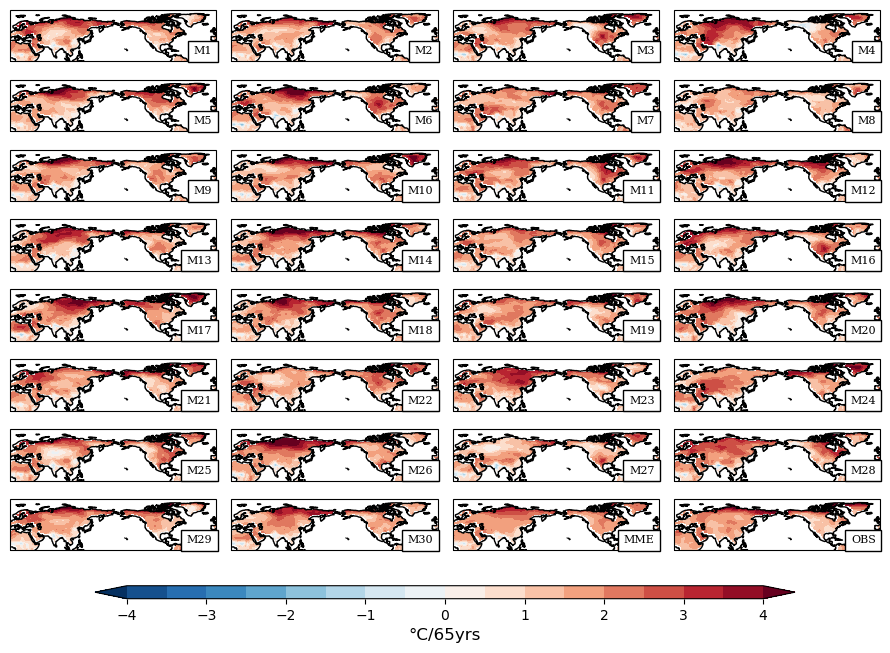

In [44]:
#Plot the 30run SAT trend pattern, MME and the OBS spatial pattern

# Assuming 'model_members' is a list of 30 2D arrays for the model members, 'ensemble_mean' is the 2D array for the ensemble mean,
# 'observational_data' is the 2D array for the observational data.
# Titles for individual subplots (change these titles as per your specific model members)
titles_model = ['M{}'.format(i+1) for i in range(len(model_members))]

# Title for the MME plot
title_mme = 'MME'

# Title for the observational plot
title_observation = 'OBS'

fig, axs = plt.subplots(8, 4, figsize=(10, 6.5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Add a title for the entire figure
# fig.suptitle('Northern Hemisphere SAT Regression Patterns', fontsize=14, fontweight='bold', y=0.95, x=0.5)

for i, ax in enumerate(axs.flat):
    if i < len(model_members):
        im = plot_regression_map(slope_SON_data[i,::-1,:], ax, titles_model[i])
    elif i == len(model_members):
        im = plot_regression_map(slope_SON_MME[::-1,:], ax, title_mme)
    else:
        im = plot_regression_map(SAT_trend['SON'][::-1,:], ax, title_observation)

# Add a common colorbar for all subplots
cax = fig.add_axes([0.20, 0.01, 0.7, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('°C/65yrs', fontsize=12)

plt.tight_layout(rect=[0.1, 0.05, 1, 0.95])  # Adjust the layout to accommodate the suptitle and colorbar
plt.savefig('1958-MPI-ESM-LR_SON_65yr_trend_subplot-MME-OBS.png', bbox_inches='tight', dpi=300)

plt.show()